**Отчет**

На первом этапе я рассмотрел подходы к валидации модели, нашел либы в питоне (кроме Prophet), которые позволяют работать с временными рядами для того, чтобы получить оценки качества, с которыми будут сравниваться разрабатываемая модель. Реализовал небольшой ноутбук, чтобы прогнать эти метрики над данными в первом приближении.

Ниже краткие тезисы, которые являются выводом по работе на текущем этапе и являются основой для плана для второго этапа.


1) Есть разные стратегии для разделения time series выборки на train-test. Если реализовывать удобную python-обертку над библиотекой для бизнес-пользователя, то есть предложение во frontend прототип включить функцию train_test_split  в сигнатуру которой можно учесть параметр(-ы), ответственные за тип сплита.

Подходы описаны здесь:

https://otexts.com/fpp2/accuracy.html
(применительно к кросс-валидации)

http://www.dcc.fc.up.pt/~ltorgo/STDM_JSI/Slides/timeSeriesEvaluation_handouts.pdf
(5 слайд)


2)Для анализа качества модели недостаточно стандартных метрик rmse, mae, rmsle. Более полный перечень может быть найден в следующей работе (более 2к цитирований.):

Hyndman, R. J., & Koehler, A. B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting, 22, 679–688.


Представляется правильным в разрабатываемой библиотеке реализовать их все.


3) Для работы с временными рядами также необходимо проверять разные гипотезы: нормальность и нескоррелированность остатков, проверка на стационарность. Представляется важным их вшить в отчет о построении модели.


4)В дополнение к п3. Если ряд нестационарен или остатки скоррелированнны, то возможны ряд процедур (диффиренцирование, процедура Кахрейна-Орката,  процедура Дарбина), которыми можно воспользоваться, для того, чтобы корректно работать  с рядами.


В связи с  этими пунктами план на второй этап выглядит следющим образом.


1) Прогнать все метрики над всеми подобранными датасетами в питоне.

2) Написать прототип в питоне train-test split для всех типов подходов.

3) Составить список проверок гипотез, которые оптимально иметь в составе билиотеки. Написать прототип их реализации на питоне или С++.

4) Составить полный список процедур, которые можно было бы реализовать и отранжировать его. Если останется время, то запрототипировать топ 1.

In [2]:
pip install ml_metrics

In [3]:
pip uninstall statsmodels

Uninstalling statsmodels-0.9.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/statsmodels-0.9.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.9.0


In [4]:
pip install statsmodels

  Using cached https://files.pythonhosted.org/packages/85/d1/69ee7e757f657e7f527cbf500ec2d295396e5bcec873cf4eb68962c41024/statsmodels-0.9.0-cp36-cp36m-manylinux1_x86_64.whl


При написании отчета активно пользовался следующим статьями: 

https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051


In [0]:
import statsmodels
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics

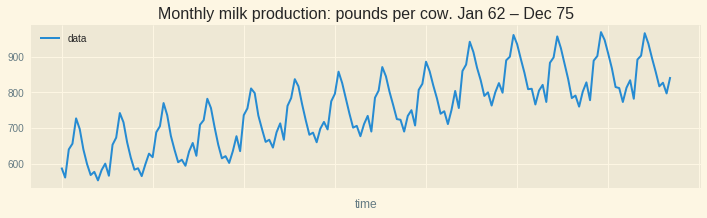

In [33]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('Solarize_Light2')

r = requests.get('https://datamarket.com/api/v1/list.json?ds=22ox')
jobj = json.loads(r.text[18:-1])
data = jobj[0]['data']
df = pd.DataFrame(data, columns=['time','data']).set_index('time')
train = df.iloc[:-24, :]
test = df.iloc[-24:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3));
plt.title(jobj[0]['title']);

Разделение на train-test следующее данные до 1974 года в train, 1974, 1975 - test. 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


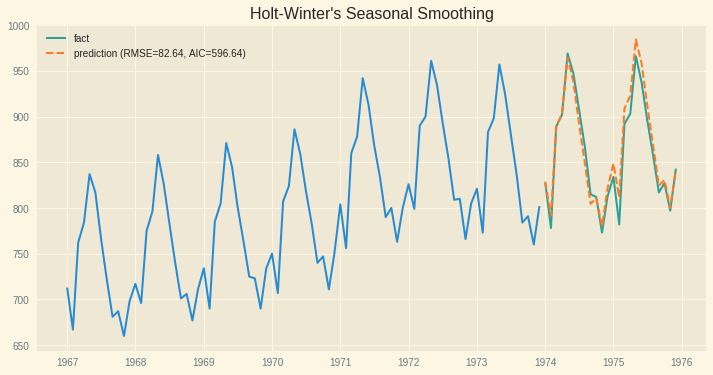

In [34]:
import statsmodels.tsa.holtwinters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()
pred = fit.forecast(24)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='fact');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

In [35]:
print('MSE, Test:', metrics.mse(test.values, pred.values))
print('RMSE, Test:', metrics.rmse(test.values, pred.values))
print('MAE, Test:', metrics.mae(test.values, pred.values))
print('RMSLE, Test:', metrics.rmsle(test.values, pred.values))

MSE, Test: 6828.755896366316
RMSE, Test: 82.63628680166066
MAE, Test: 66.68131182826448
RMSLE, Test: 0.09477795667994138


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                   data   No. Observations:                  168
Model:                     ARMA(0, 0)   Log Likelihood                  95.346
Method:                           css   S.D. of innovations              0.137
Date:                Sat, 23 Mar 2019   AIC                           -186.692
Time:                        13:21:14   BIC                           -180.444
Sample:                    01-01-1962   HQIC                          -184.157
                         - 12-01-1975                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6170      0.011    625.221      0.000       6.596       6.638
                             ARIMA Model Results                              
Dep. Variable:                 D.data   No. Observat

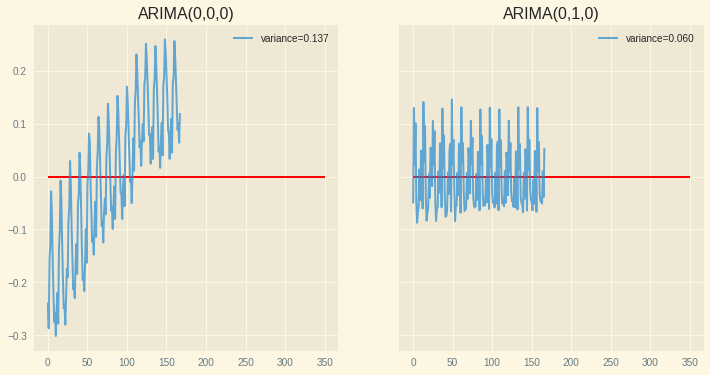

In [37]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df.data).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df.data).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

2. Данные о потреблении энергии

https://www.kaggle.com/robikscube/hourly-energy-consumption

In [0]:
pc = pd.read_csv('AEP_hourly.csv', ',')

In [4]:
pc.head()

Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0

In [0]:
pc = pc.iloc[120500:]

In [21]:
test.shape[0]

272

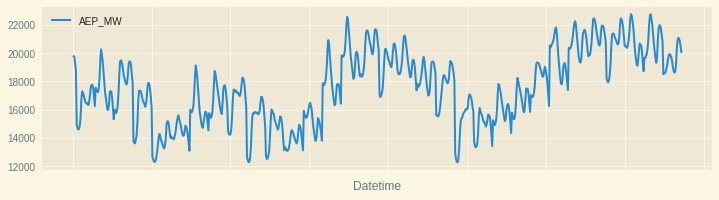

In [19]:
plt.style.use('Solarize_Light2')
df = pd.DataFrame(pc, columns=['Datetime','AEP_MW']).set_index('Datetime')
train = df.iloc[:500]
test = df.iloc[501:]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3));
plt.title('');

In [26]:
import statsmodels.tsa.holtwinters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train,trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()
pred = fit.forecast(test.shape[0])

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values);
ax.plot(test.index, test.values, label='fact');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="prediction (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [27]:
print('MSE, Test:', metrics.mse(test.values, pred.values))
print('RMSE, Test:', metrics.rmse(test.values, pred.values))
print('MAE, Test:', metrics.mae(test.values, pred.values))
print('RMSLE, Test:', metrics.rmsle(test.values, pred.values))

MSE, Test: 68444699.66961321
RMSE, Test: 8273.131188952175
MAE, Test: 6871.629064097984
RMSLE, Test: 0.3639120696979561


Настройка ARIMA.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                 AEP_MW   No. Observations:                  773
Model:                     ARMA(0, 0)   Log Likelihood                 386.480
Method:                           css   S.D. of innovations              0.147
Date:                Sat, 23 Mar 2019   AIC                           -768.959
Time:                        13:04:49   BIC                           -759.659
Sample:                             0   HQIC                          -765.381
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7631      0.005   1849.484      0.000       9.753       9.773
                             ARIMA Model Results                              
Dep. Variable:              D2.AEP_MW   No. Observat

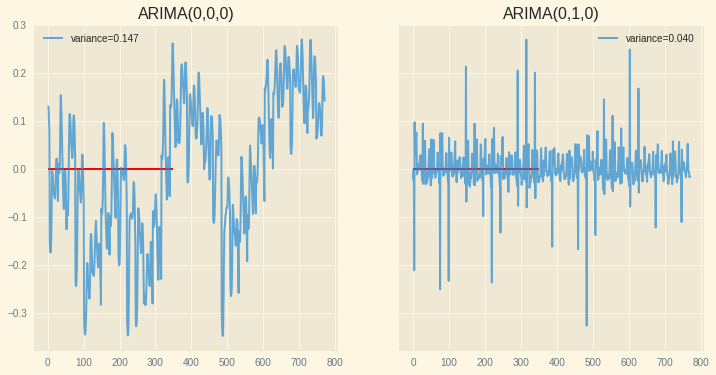

In [32]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df.AEP_MW).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df.AEP_MW).dropna(), (1, 2, 1))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();